<a href="https://colab.research.google.com/github/Shreya-Mendi/ReinforcementLearning/blob/main/lab2/lab2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 2
### Tabular RL on FrozenLake: Planning vs Learning


#### Learning Goals

By the end of this lab, you should be able to:

* Describe an RL problem as an MDP: ⟨S, A, P, R, γ⟩

* Compute an optimal value function using Value Iteration (planning; model-based)

* Learn an optimal action-value function using Q-learning (learning; model-free)

* Explain how both use the same core idea: Bellman optimality backups

Run on Google Colab:

[![Open In Collab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/duke-trust-lab/intro_modern_rl/blob/main/lab2/lab2.ipynb)

In [87]:
%pip install -q gymnasium

import gymnasium as gym
import numpy as np
import random
from tqdm.auto import tqdm
import pandas as pd
import matplotlib.pyplot as plt

### Setting up a reproducible environment

FrozenLake is a finite MDP, which makes it ideal for studying tabular methods.

We set:

`is_slippery=False` so transitions are deterministic
* this isolates Bellman updates from stochastic noise
* we will turn stochasticity back on later



This environment gives us:

A finite state space (S)

A finite action space (A)

A well-defined transition model P(s′ | s, a)

A reward function R(s, a, s′)

In [88]:
SEED = 42
np.random.seed(SEED)
random.seed(SEED)

# Deterministic dynamics. We'll flip is_slippery=True later!
env = gym.make("FrozenLake-v1", map_name="4x4", is_slippery=False, render_mode="rgb_array")

_ = env.reset(seed=SEED)
env.action_space.seed(SEED)
env.observation_space.seed(SEED)

nS = env.observation_space.n
nA = env.action_space.n

print("nS (states) =", nS)
print("nA (actions) =", nA)

nS (states) = 16
nA (actions) = 4


### The MDP

FrozenLake is a finite MDP:

**States:** S = {0, 1, …, 15} (each tile in the 4×4 grid)

**Actions:** A = {0, 1, 2, 3} (LEFT, DOWN, RIGHT, UP)

**Transitions:** P(s′ | s, a)

**Reward:** typically 1 when you reach the goal, else 0

**Discount:** γ ∈ [0, 1)

We are going to extract the environment’s transition model **P** and inspect it.

In [89]:
# In FrozenLake, env.unwrapped.P is a dict-like structure: P[s][a] = list of (prob, next_state, reward, terminated)
P = env.unwrapped.P

# sanity checks
print("Keys in P (states):", list(P.keys())[:5], "...")
print("Example transitions P[0][0]:", P[0][0])


Keys in P (states): [0, 1, 2, 3, 4] ...
Example transitions P[0][0]: [(1.0, 0, 0, False)]


### Checkpoint


> 1. What does each tuple (prob, next_state, reward, terminated) mean?

> 2. Why is Value Iteration possible here, but not always in real-world RL?







In [90]:
def pretty_print_transitions(P, s, action_names=None):
    """
    Print the transition dynamics for each action at state s.

    P[s][a] is a list of tuples:
      (probability, next_state, reward, terminated)
    """
    if action_names is None:
        action_names = {0: "LEFT", 1: "DOWN", 2: "RIGHT", 3: "UP"}

    print(f"State {s}")
    for a in P[s]:
        action_label = action_names.get(a, f"ACTION {a}")
        print(f"  Action {action_label}:")
        for (p, s_next, r, done) in P[s][a]:
            print(f"    → (p={p:.2f}, s'={s_next}, r={r:.1f}, done={done})")

pretty_print_transitions(P, s=0)

State 0
  Action LEFT:
    → (p=1.00, s'=0, r=0.0, done=False)
  Action DOWN:
    → (p=1.00, s'=4, r=0.0, done=False)
  Action RIGHT:
    → (p=1.00, s'=1, r=0.0, done=False)
  Action UP:
    → (p=1.00, s'=0, r=0.0, done=False)


### Value Functions and Bellman Optimality

We’ll use two value functions:

State-value under a policy π:
Vπ(s) = E[ Σₜ γᵗ rₜ | s₀ = s, π ]

Optimal value:
V*(s) = maxπ Vπ(s)

Bellman optimality equation for V*:

V*(s) = maxₐ Σₛ′ P(s′|s,a) [ R(s,a,s′) + γ V*(s′) ]

*Value Iteration repeatedly applies this “backup” until values stop changing*



---


This function implements one Bellman backup for a single state s

Given:

Current value estimates V

Transition model P

Discount factor γ

In [91]:
def bellman_optimality_backup(P, V, s, gamma):
    """
    Compute:
      max_a Σ_s' P(s'|s,a) [ r + γ V(s') ]
    TODO: implement this function.

    Inputs:
      P: transition model
      V: np.array shape [nS]
      s: int state
      gamma: float

    Returns:
      v_new: float
    """
    # TODO:
    #   For each action a:
    #     compute expected return = Σ over transitions (p * (r + gamma*V[s']))
    #   return the max over

    v_new = 0.0
    for a in P[s]:
        v_new_a = 0.0
        for (p, s_next, r, done) in P[s][a]:
            v_new_a += p * (r + gamma*V[s_next])
        v_new = max(v_new, v_new_a)

    return v_new

This function repeatedly applies Bellman backups to all states:

Initialize V(s) arbitrarily (zeros)

For each state:

Update V(s) using the Bellman optimality equation

Stop when values stop changing (convergence)

In [92]:
def value_iteration(P, nS, nA, gamma=0.95, theta=1e-8, max_iters=10_000):
    """
    Classic Value Iteration for V*.

    TODO:
      - implement the update for each state using bellman_optimality_backup
      - stop when max change < theta

    Returns:
      V: optimal state-value np.array shape [nS]
    """
    V = np.zeros(nS, dtype=np.float64)

    for it in range(max_iters):
        delta = 0.0

        # TODO: loop over states s
        #   v_old = V[s]
        #   V[s] = bellman_optimality_backup(...)
        #   delta = max(delta, abs(v_old - V[s]))
        for s in range(nS):
            v_old = V[s]
            V[s] = bellman_optimality_backup(P, V, s, gamma)
            delta = max(delta, abs(v_old - V[s]))

        if delta < theta:
            print(f"Value Iteration converged in {it+1} iterations (delta={delta:.2e}).")
            break

    return V

gamma = 0.95
V_star = value_iteration(P, nS, nA, gamma=gamma)
V_star[:10]

Value Iteration converged in 7 iterations (delta=0.00e+00).


array([0.77378094, 0.81450625, 0.857375  , 0.81450625, 0.81450625,
       0.        , 0.9025    , 0.        , 0.857375  , 0.9025    ])

Once we have V*(s), we compute:

π*(s) = argmaxₐ Σₛ′ P(s′|s,a) [ r + γ V*(s′) ]

In [93]:
def greedy_policy_from_V(P, V, nS, nA, gamma=0.95):
    """
    π(s) = argmax_a Σ_s' P(s'|s,a) [ r + γ V(s') ]
    TODO: implement.

    Returns:
      pi: np.array shape [nS] containing action index per state
    """
    pi = np.zeros(nS, dtype=np.int64)
    # TODO: fill pi[s] for each state s
    #   pi[s] = argmax_a Σ_s' P(s'|s,a) [ r + γ V(s') ]
    for s in range(nS):
        v_max = -np.inf
        for a in P[s]:
            v_new = 0.0
            for (p, s_next, r, done) in P[s][a]:
                v_new += p * (r + gamma*V[s_next])
            if v_new > v_max:
                v_max = v_new
                pi[s] = a
    return pi

pi_vi = greedy_policy_from_V(P, V_star, nS, nA, gamma=gamma)
pi_vi


array([1, 2, 1, 0, 1, 0, 1, 0, 2, 1, 1, 0, 0, 2, 2, 0])

This function:

Executes a fixed policy π in the environment

Runs multiple episodes

Returns the average reward

In [94]:
def evaluate_policy(env, pi, episodes=200, max_steps=200):
    returns = []
    for _ in range(episodes):
        s, _ = env.reset(seed=None)
        total = 0.0
        for _ in range(max_steps):
            a = int(pi[s])
            s, r, terminated, truncated, _ = env.step(a)
            total += r
            if terminated or truncated:
                break
        returns.append(total)
    return float(np.mean(returns)), float(np.std(returns))

mean_vi, std_vi = evaluate_policy(env, pi_vi, episodes=200)
print("Value Iteration policy performance:")
print("  mean return =", mean_vi, "std =", std_vi)

Value Iteration policy performance:
  mean return = 1.0 std = 0.0


### Checkpoint

> 1. Value Iteration never “plays the game” to learn. So how does it improve?


> 2. What assumption does Value Iteration require that Q-learning does not?


### Q-learning (Learning / Model-Free Control)

Q-learning learns an action-value table Q(s,a) using sampled experience

The update is:

Q(s,a) ← Q(s,a) + α [ r + γ maxₐ′ Q(s′,a′) − Q(s,a) ]

This is a sampled Bellman optimality backup

---

Q-learning maintains a table Q(s,a) and updates it via:

Q(s,a) ← Q(s,a) + α [ r + γ maxₐ′ Q(s′,a′) − Q(s,a) ]


This is a sampled Bellman optimality backup:

No transition model needed

Uses experience tuples (s, a, r, s′)

---

`epsilon_greedy_action`

This function implements ε-greedy exploration:

With probability ε: explore (random action)

With probability 1−ε: exploit (best known action)

In [95]:
Q = np.zeros((nS, nA), dtype=np.float64)

def greedy_action(Q, s):
    """Return argmax_a Q(s,a)."""
    return int(np.argmax(Q[s]))

def epsilon_greedy_action(env, Q, s, epsilon):
    """
    With probability epsilon: random action
    Otherwise: greedy action

    TODO: implement.
    """
    # TODO:
    #   if random.uniform(0,1) < epsilon: return env.action_space.sample()
    #   else return greedy_action(Q,s)
    if random.uniform(0,1) < epsilon:
        return env.action_space.sample()
    else:
        return greedy_action(Q,s)
    return 0


In [96]:
def epsilon_schedule(episode, eps_start=1.0, eps_min=0.05, decay_rate=0.0005):
    """
    Exponential decay:
      eps = max(eps_min, eps_start * exp(-decay_rate * episode))
    TODO: implement.
    """
    eps = max(eps_min, eps_start * np.exp(-decay_rate * episode))
    return eps

This is the full agent–environment loop:

Reset environment

Choose action via ε-greedy

Observe (s′, r)

Apply Q-learning update

Repeat

In [97]:
def q_learning_train(env, Q, episodes=10_000, max_steps=100,
                     alpha=0.7, gamma=0.95,
                     eps_start=1.0, eps_min=0.05, decay_rate=0.0005):
    """
    Train Q using Q-learning with epsilon-greedy exploration.

    TODO:
      - pick action using epsilon_greedy_action
      - apply Q-learning update
    """
    for ep in tqdm(range(episodes)):
        epsilon = epsilon_schedule(ep, eps_start, eps_min, decay_rate)
        s, _ = env.reset(seed=None)

        for t in range(max_steps):
            a = epsilon_greedy_action(env, Q, s, epsilon)
            s2, r, terminated, truncated, _ = env.step(a)

            # TODO: Q-learning update
            # target = r + gamma * max_a' Q[s2, a']   (if not terminal; optional nuance)
            # Q[s,a] <- Q[s,a] + alpha*(target - Q[s,a])
            # Hint: np.max(Q[s2]) gives max over actions
            # Q[s, a] = ...
            target = r + gamma * np.max(Q[s2])
            Q[s, a] += alpha * (target - Q[s, a])

            if terminated or truncated:
                break
            s = s2

    return Q

Q = np.zeros((nS, nA), dtype=np.float64)
Q = q_learning_train(env, Q)
pd.DataFrame(Q).head()

  0%|          | 0/10000 [00:00<?, ?it/s]

,0,1,2,3
0,0.735092,0.773781,0.773781,0.735092
1,0.735092,0.000000,0.814506,0.773781
2,0.773781,0.857375,0.773781,0.814506
3,0.814506,0.000000,0.773781,0.773781
4,0.773781,0.814506,0.000000,0.735092


In [98]:
pi_q = np.array([greedy_action(Q, s) for s in range(nS)], dtype=np.int64)
mean_q, std_q = evaluate_policy(env, pi_q, episodes=200)
print("Q-learning policy performance:")
print("  mean return =", mean_q, "std =", std_q)

Q-learning policy performance:
  mean return = 1.0 std = 0.0


### Checkpoint


> 1. Why do we need ε-greedy at all?


> 2. What do you think happens if ε is fixed at 0.0 from the start?


In [99]:
print("Comparison (deterministic FrozenLake, is_slippery=False)")
print(f"  Value Iteration: mean={mean_vi:.3f}, std={std_vi:.3f}")
print(f"  Q-learning:      mean={mean_q:.3f}, std={std_q:.3f}")

Comparison (deterministic FrozenLake, is_slippery=False)
  Value Iteration: mean=1.000, std=0.000
  Q-learning:      mean=1.000, std=0.000


This cell reshapes the optimal value function V*(s) from a 1-D table into the original 4×4 grid layout of FrozenLake, and displays it as a heatmap.

Each cell in the grid corresponds to:

A state in the environment

The estimated expected discounted return starting from that state, assuming optimal behavior

Darker (or brighter) colors indicate states with higher expected return.

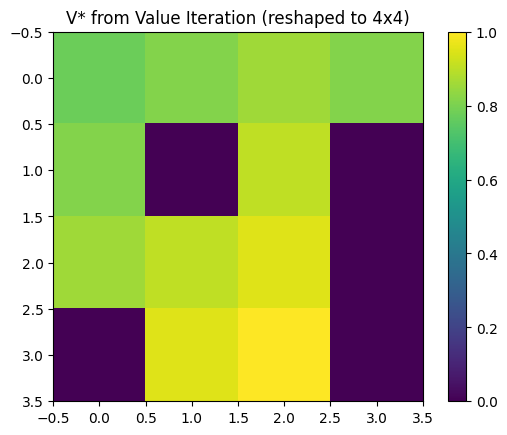

In [100]:
V_grid = V_star.reshape(4,4)
plt.figure()
plt.title("V* from Value Iteration (reshaped to 4x4)")
plt.imshow(V_grid)
plt.colorbar()
plt.show()

### Turn on Stochasticity

Now `flip is_slippery=True`

This introduces stochastic transitions. Your MDP model still exists, but learning becomes noisier and evaluation has variance.

In [101]:
env_slip = gym.make("FrozenLake-v1", map_name="4x4", is_slippery=True, render_mode="rgb_array")
_ = env_slip.reset(seed=SEED)
env_slip.action_space.seed(SEED)
env_slip.observation_space.seed(SEED)

P_slip = env_slip.unwrapped.P

In [102]:
# Value Iteration policy on slippery dynamics
V_star_slip = value_iteration(P_slip, nS, nA, gamma=gamma)
pi_vi_slip = greedy_policy_from_V(P_slip, V_star_slip, nS, nA, gamma=gamma)
mean_vi_s, std_vi_s = evaluate_policy(env_slip, pi_vi_slip, episodes=500)

# Q-learning on slippery dynamics
Q_slip = np.zeros((nS, nA), dtype=np.float64)
Q_slip = q_learning_train(env_slip, Q_slip, episodes=20_000)  # more episodes helps
pi_q_slip = np.array([greedy_action(Q_slip, s) for s in range(nS)], dtype=np.int64)
mean_q_s, std_q_s = evaluate_policy(env_slip, pi_q_slip, episodes=500)

print("Comparison (stochastic FrozenLake, is_slippery=True)")
print(f"  Value Iteration: mean={mean_vi_s:.3f}, std={std_vi_s:.3f}")
print(f"  Q-learning:      mean={mean_q_s:.3f}, std={std_q_s:.3f}")

Value Iteration converged in 138 iterations (delta=9.72e-09).


  0%|          | 0/20000 [00:00<?, ?it/s]

Comparison (stochastic FrozenLake, is_slippery=True)
  Value Iteration: mean=0.704, std=0.456
  Q-learning:      mean=0.766, std=0.423


In [103]:
import numpy as np
import gymnasium as gym
from gymnasium.wrappers import RecordVideo

# Train
Q_slip = np.zeros((nS, nA), dtype=np.float64)
Q_slip = q_learning_train(env_slip, Q_slip, episodes=20_000)
pi_q_slip = np.array([greedy_action(Q_slip, s) for s in range(nS)], dtype=np.int64)
mean_q_s, std_q_s = evaluate_policy(env_slip, pi_q_slip, episodes=500)

 # Fresh env for recording
env_rec = gym.make("FrozenLake-v1", render_mode="rgb_array", is_slippery=True)
env_rec = RecordVideo(env_rec, video_folder="videos", episode_trigger=lambda eid: eid == 0)

# One episode using the trained Q_slip
state, _ = env_rec.reset()
done = False

while not done:
    action = int(np.argmax(Q_slip[state]))
    state, reward, terminated, truncated, _ = env_rec.step(action)
    done = terminated or truncated

env_rec.close()

from IPython.display import Video

Video("videos/rl-video-episode-0.mp4", embed=True)

  0%|          | 0/20000 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/gymnasium/wrappers/rendering.py:293: UserWarning: WARN: Overwriting existing videos at /content/videos folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(
